# Assignment 2
## Facial Point Detection

This assignment approaches the computer vision problem of detecting facial keypoints in an image using deep learning techniques.

The training dataset consists of 7,049 96x96 gray-scale images. For each image, we're supposed learn to find the correct position (the ``x`` and ``y`` coordinates) of 15 2D keypoints, such as ``left_eye_center, right_eye_outer_corner, mouth_center_bottom_lip``, and so on. For some of the keypoints we only have about 2,000 labels, while other keypoints have more than 7,000 labels available for training.

In the following lines we provide a simple solution. This model can be used to provide a baseline result to be used for comparison.

The objectives of this assignment are:
+ To develop a better solution by changing the baseline model.
+ To increase performance by using several tricks :
    + Data augmentation: flipped images, greylevel image editing, etc. You can explore the Keras image augmentation layers https://keras.io/api/layers/preprocessing_layers/image_augmentation/
    + SGD: Changing learning rate and momentum over time.
    + Training: Using regularization techniques such as Dropout.
    + Instead of training a single model, train a few specialist networks, with each one predicting a different subset of target values (f.e. eye features, mouth features, etc.).
    + Etc.
+ To transform your solution in a Fully Convolutional Network (FCN) to make it independent of the input image size!


> You will need **GPU computation**. Consider the use of Colab!
    
At the end of the notebook you must report:
+ What is the best result you got when testing.
+ What architecture and tricks you used for that result.
+ How you have implemented the FCN (including one inference example).

The final model can be developed in Tensorflow or in Keras.

In [ ]:
# downloading data

%matplotlib inline

import numpy as np
import matplotlib
from matplotlib import pyplot
import os
import time

from pandas import DataFrame
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
!wget https://www.dropbox.com/s/svrvpus93131m98/test.csv
!wget https://www.dropbox.com/s/xzm5f5vrx6jwqui/training.csv

# These files are also available in campus virtual

--2022-11-25 12:36:17--  https://www.dropbox.com/s/svrvpus93131m98/test.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/svrvpus93131m98/test.csv [following]
--2022-11-25 12:36:17--  https://www.dropbox.com/s/raw/svrvpus93131m98/test.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc3baba0992be0280755c644acc0.dl.dropboxusercontent.com/cd/0/inline/BxaQXkNF_NMjgnhvH63NcNNL0orFvmv5nRBVglFxMTkyqKdgLGs6-HViW-sBKE8uJ-_ijiNk7cikYjf0MMbOls1W652pbQy0y_t8YinyZdlH1_3eHTxGURF1xPuZ5TcQkXiTCUPtONyR9xFwlMxN6bav1QTkVun_uHkfGfi3J-IrrQ/file# [following]
--2022-11-25 12:36:18--  https://uc3baba0992be0280755c644acc0.dl.dropboxusercontent.com/cd/0/inline/BxaQXkNF_NMjgnhvH63NcNNL0orFvmv5nRBVglFxMTkyqKdgLGs6-HViW-sBKE8uJ-_ijiNk7cikYjf0MMbOls1W652p

## Data exploration

In [ ]:
# loading data

FTRAIN = 'training.csv'
FTEST = 'test.csv'
FLOOKUP = 'IdLookupTable.csv'

def load(test = False, cols = None):
    """
    Loads the dataset.
    Returns a tuple of X and y, if `test` was set to `True` y contains `None`.    
    """
    
    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep = ' '))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]
    print("There are missing points:")
    print(df.count())  # prints the number of values for each column
    df = df.dropna()  # drop all rows that have missing values in them

    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None

    return X.reshape(df.shape[0],96,96), y

def plot_sample(x, y):
    """
    Plots a single sample image with keypoints on top.   
    """
    pyplot.imshow(x, cmap='gray')
    pyplot.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

There are missing points:
left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_li

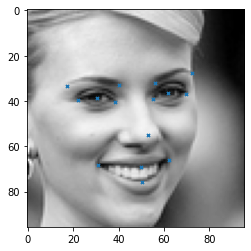

In [ ]:
# loading data and checking it

X, y = load()
plot_sample(X[12],y[12])

In [ ]:
# Split the initial training dataset into training, validation and testing datasets.
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size = 0.5)

# Make sure images have shape (96, 96, 1) - Keras requirement!
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
x_valid = np.expand_dims(x_valid, -1)
print(x_train.shape)
print(y_train.shape)

(1498, 96, 96, 1)
(1498, 30)


##Data augmentation

We have done several tricks to increase the data:

+ Flipped images
+ Blurred images
+ Darker images
+ Brighter images
+ Add noise

In [ ]:
#Function that flips an image and their points
def flip(images,keypoints):
  #Flip the image
  flipped_im = np.copy(images)[:,:,::-1,:]
  #Construction of the new set of points
  flipped_keypoints = np.zeros(keypoints.shape)
  #Flip the keypoints
  for i in range(images.shape[0]):
    #X coordinate
    flipped_keypoints[i,:] = keypoints[i,:]
    flipped_keypoints[i,0::2] *= -1
    #Flip the labels
    flip_indices = [(0, 2), (1, 3),(4, 8), (5, 9), (6, 10), (7, 11),(12, 16), (13, 17), (14, 18), (15, 19),(22, 24), (23, 25)]
    for j,k in flip_indices:
      aux = flipped_keypoints[i,j]
      flipped_keypoints[i,j] = flipped_keypoints[i,k]
      flipped_keypoints[i,k] = aux
  return flipped_im, flipped_keypoints


#Function that apply a multidimensional Gaussian filter to the image in order to blur them
from scipy.ndimage.filters import gaussian_filter
def blurred_image(images):
  blurred_im = np.zeros(images.shape)
  for i in range(images.shape[0]):
    blurred_im[i,:,:,:] = gaussian_filter(images[i,:,:,:], sigma=1.5)
  return blurred_im


#Function that darkens an image
def darker(images):
  dark_im = np.zeros(images.shape)
  for i in range(images.shape[0]):
    dark_im[i,:,:,:] = images[i,:,:,:]/2
  return dark_im

#Function that brightens an image
def brighter(images):
  brighter_im = np.zeros(images.shape)
  for i in range(images.shape[0]):
    brighter_im[i,:,:,:] = (images[i,:,:,:] + 1)/2
  return brighter_im

#Function that add noise. Since we have 96x96 pictures, 6% noise --> 550 pixels 
def add_noise(images):
  ind_x = np.random.randint(0,96,550)
  ind_y = np.random.randint(0,96,550)
  aux = np.copy(images)
  aux[:,ind_x,ind_y,:] = 0
  noise_im = aux
  return noise_im

In [ ]:
#Function to plot two images in the same cell

def plot_2(x1,y1,x2,y2,image_number):
  fig = pyplot.figure(figsize=(12,12))
  ax1 = fig.add_subplot(121)
  ax1.set_title('Original iamge')
  ax1.imshow(np.squeeze(x1[image_number]), cmap='gray')
  ax1.scatter(y1[image_number,0::2] * 48 + 48, y1[image_number,1::2] * 48 + 48, marker='x', c='c', s=10)
  ax2 = fig.add_subplot(122)
  ax2.set_title('Transformed image')
  ax2.imshow(np.squeeze(x2[image_number]), cmap='gray')
  ax2.scatter(y2[image_number,0::2] * 48 + 48, y2[image_number,1::2] * 48 + 48, marker='x', c='c', s=10)

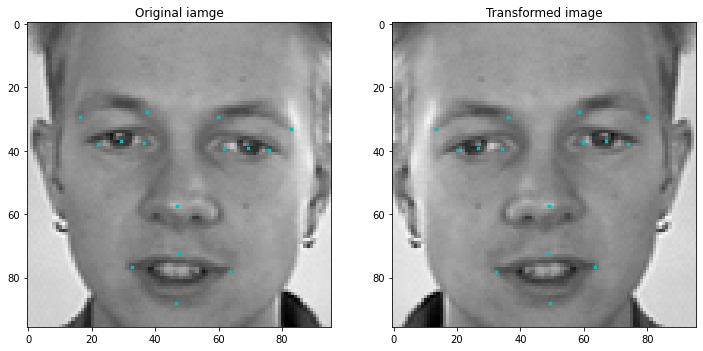

In [ ]:
#Let us check if we have flipped correctly
flipped_x,flipped_y = flip(x_train,y_train)
plot_2(x_train,y_train,flipped_x,flipped_y, 10) #change the last number if it is not clear enough

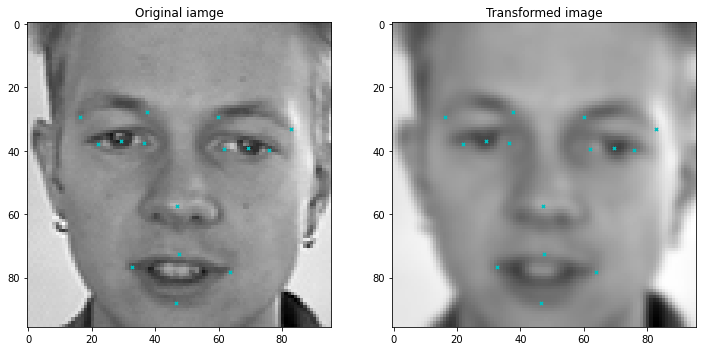

In [ ]:
#Let us check if we have blur the image correctly
blur = blurred_image(x_train)
plot_2(x_train,y_train,blur,y_train, 10) #change the last number if it is not clear enough

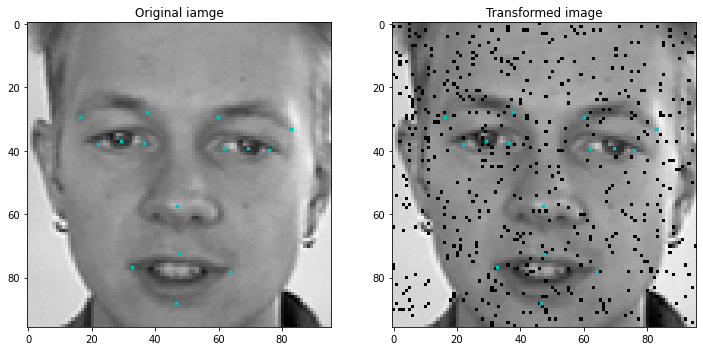

In [ ]:
#Let us check if we have add noise correctly
noise = add_noise(x_train)
plot_2(x_train,y_train,noise,y_train, 10)

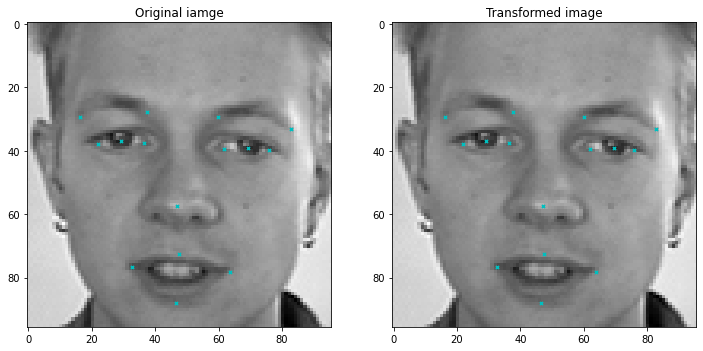

In [ ]:
#Let us check if we darkens an image correctly
dark = darker(x_train)
plot_2(x_train,y_train,dark,y_train, 10)

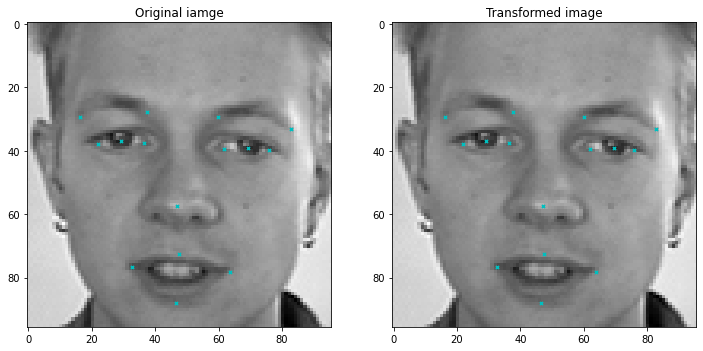

In [ ]:
#Let us check if we brightens an image correctly
bright = brighter(x_train)
plot_2(x_train,y_train,bright,y_train, 10)

Notice that in the last two cases, images looks really similar. It seems that we have not managed to darken or brighten the image. This is due to the plot, which normalizes the ranges so the image looks the same. Nevertheless, notice that the values of the arrays have changed:

In [ ]:
print(np.linalg.norm(x_train-dark))
print(np.linalg.norm(x_train-bright))

980.8548622884756
1067.0269294387656


In [ ]:
#Let us concatenate the data in order to increase the training set and complete the data augmentation
X_aug = np.concatenate((x_train,flipped_x,blur,dark,bright,noise))
y_aug = np.concatenate((y_train,flipped_y,y_train,y_train,y_train,y_train))
print(X_aug.shape)

(8988, 96, 96, 1)


## Model

In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

# Predefined parameters
input_shape = (96, 96, 1)
output_shape = 30

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
     
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
     
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
     
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),

     
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(output_shape, activation="linear"),
    ]
)

model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_51 (Conv2D)          (None, 96, 96, 32)        320       
                                                                 
 conv2d_52 (Conv2D)          (None, 96, 96, 32)        9248      
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 48, 48, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_53 (Conv2D)          (None, 48, 48, 64)        18496     
                                                                 
 conv2d_54 (Conv2D)          (None, 48, 48, 64)        36928     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                 

In [ ]:
from keras.optimizers import SGD
sgd = SGD(learning_rate = 0.01, momentum = 0.9, nesterov = True)

In [ ]:
batch_size = 16
epochs = 500 #early stopping will stop the program before

from keras import backend as K
from keras.callbacks import EarlyStopping

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

model.compile(loss=root_mean_squared_error, optimizer=sgd)
callback_list = [EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, verbose=1, mode='auto')]
model.fit(X_aug, y_aug, batch_size=batch_size, epochs=epochs, validation_split=0.2, shuffle = True, callbacks = callback_list)

Epoch 1/500
450/450 [==============================] - 8s 17ms/step - loss: 0.0874 - val_loss: 0.0693
Epoch 2/500
450/450 [==============================] - 7s 16ms/step - loss: 0.0706 - val_loss: 0.0708
Epoch 3/500
450/450 [==============================] - 6s 14ms/step - loss: 0.0695 - val_loss: 0.0674
Epoch 4/500
450/450 [==============================] - 7s 14ms/step - loss: 0.0685 - val_loss: 0.0669
Epoch 5/500
450/450 [==============================] - 6s 14ms/step - loss: 0.0679 - val_loss: 0.0670
Epoch 6/500
450/450 [==============================] - 6s 14ms/step - loss: 0.0673 - val_loss: 0.0671
Epoch 7/500
450/450 [==============================] - 6s 14ms/step - loss: 0.0663 - val_loss: 0.0647
Epoch 8/500
450/450 [==============================] - 6s 14ms/step - loss: 0.0652 - val_loss: 0.0631
Epoch 9/500
450/450 [==============================] - 6s 14ms/step - loss: 0.0638 - val_loss: 0.0613
Epoch 10/500
450/450 [==============================] - 6s 14ms/step - loss: 0.061

In [ ]:
y_new = model.predict(x_valid)

def rmse_pixel(y_true, y_pred):
        return np.sqrt(np.mean(np.square(y_pred*48 - y_true*48)))

print("Mean pixel error: ", rmse_pixel(y_valid, y_new))

11/11 [==============================] - 0s 8ms/step
Mean pixel error:  1.3177782


##Examples

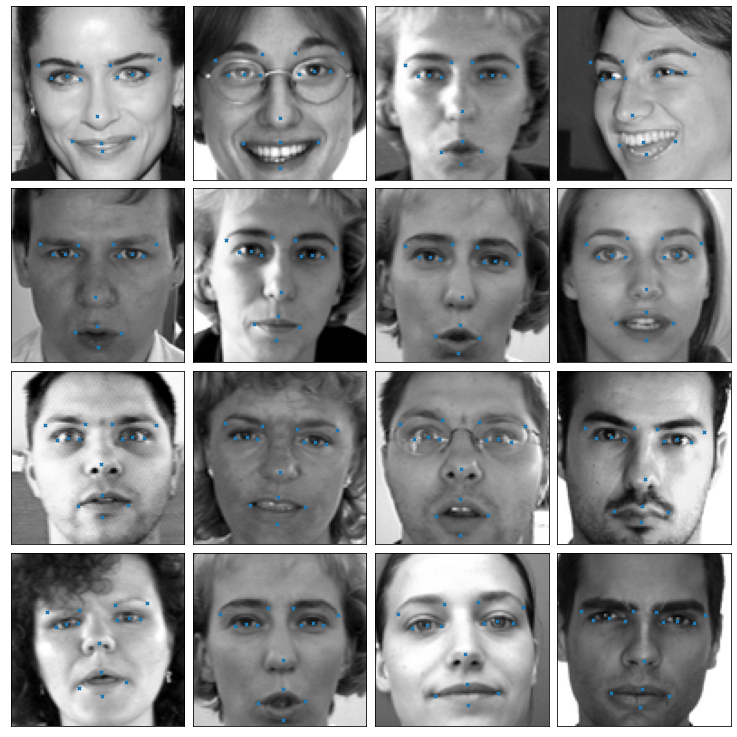

In [ ]:
fig = pyplot.figure(figsize=(10, 10))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(x_valid[i,:,:,0],y_new[i])
pyplot.show()

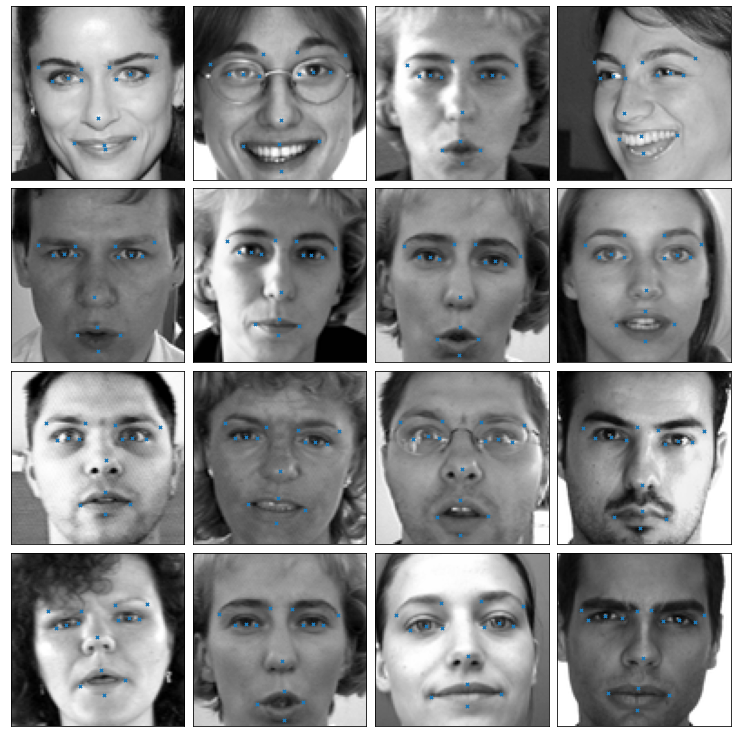

In [ ]:
fig = pyplot.figure(figsize=(10, 10))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(x_valid[i,:,:,0],y_valid[i])

pyplot.show()

## Fully Convolutional Network (FCN)

Let us implement a FCN in order to to make the neural network independent of the input image size.

In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

# Predefined parameters
input_shape = (None, None, 1)
output_shape = 30

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
     
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
     
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
     
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        
        layers.Dropout(0.5),
        layers.Conv2D(output_shape, kernel_size=(6, 6), activation="linear"),
        layers.Flatten()

     
        
    ]
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, None, None, 32)    320       
                                                                 
 conv2d_10 (Conv2D)          (None, None, None, 32)    9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, None, None, 32)   0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, None, None, 64)    18496     
                                                                 
 conv2d_12 (Conv2D)          (None, None, None, 64)    36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, None, None, 64)   0         
 2D)                                                  

In [ ]:
batch_size = 16
epochs = 500 #early stopping will stop the program before

from keras import backend as K
from keras.callbacks import EarlyStopping

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

model.compile(loss=root_mean_squared_error, optimizer=sgd)
callback_list = [EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, verbose=1, mode='auto')]
model.fit(X_aug, y_aug, batch_size=batch_size, epochs=epochs, validation_split=0.2, shuffle = True, callbacks = callback_list)

Epoch 1/500
450/450 [==============================] - 9s 16ms/step - loss: 0.0870 - val_loss: 0.0664
Epoch 2/500
450/450 [==============================] - 7s 15ms/step - loss: 0.0701 - val_loss: 0.0676
Epoch 3/500
450/450 [==============================] - 7s 15ms/step - loss: 0.0690 - val_loss: 0.0671
Epoch 4/500
450/450 [==============================] - 7s 15ms/step - loss: 0.0683 - val_loss: 0.0659
Epoch 5/500
450/450 [==============================] - 7s 15ms/step - loss: 0.0679 - val_loss: 0.0660
Epoch 6/500
450/450 [==============================] - 7s 15ms/step - loss: 0.0674 - val_loss: 0.0653
Epoch 7/500
450/450 [==============================] - 7s 15ms/step - loss: 0.0668 - val_loss: 0.0644
Epoch 8/500
450/450 [==============================] - 8s 17ms/step - loss: 0.0659 - val_loss: 0.0639
Epoch 9/500
450/450 [==============================] - 7s 15ms/step - loss: 0.0646 - val_loss: 0.0622
Epoch 10/500
450/450 [==============================] - 7s 15ms/step - loss: 0.063

In [ ]:
y_new = model.predict(x_valid)

def rmse_pixel(y_true, y_pred):
        return np.sqrt(np.mean(np.square(y_pred*48 - y_true*48)))

print("Mean pixel error: ", rmse_pixel(y_valid, y_new))

11/11 [==============================] - 0s 8ms/step
Mean pixel error:  1.3352972


##Examples

Let us see that this model works for every image size. We create an image of shape 128x128.

In [ ]:
image1 = np.expand_dims(np.pad(x_valid[4][:,:,0],pad_width=16),axis=(0,3))#change the number if it is not clear enough
image2 = np.expand_dims(np.pad(x_valid[10][:,:,0],pad_width=16),axis=(0,3))#change the number if it is not clear enough
print(image1.shape)
print(image2.shape)

(1, 128, 128, 1)
(1, 128, 128, 1)


In [ ]:
y_pred1 = model.predict(image1)
y_pred2 = model.predict(image2)
print(y_pred1.shape)
print(y_pred2.shape)

1/1 [==============================] - 0s 19ms/step
(1, 270)
(1, 270)


Notice that our model has predicted nine possible positions where the points might be. Why? The model selects a 96x96 image size and gives the prediction with respect this sqaure. Since we have created images of size 128x128, nine possibles squares of size 96x96 are treated.
+ Upper$→$ left,center and right
+ Middle$→$ left,center and right
+ Bottom$→$ left,center and right

We could have chosen any other big image whose size  was divisible by two. Why? Notice that the MaxPooling operations divide by two the size of the image!! Hence, we need the image size to be divisible by two.

Let us see, which prediction is the correct one by plotting the points with the image. Although it is not the most elegant way of looking at it, it is useful. Another way to proceed would be to have a "face detector" to detect in which square our image is and plot directly the corresponding predicted points.

In [ ]:
def plot_sample_general(x, y):
    """
    Plots a single sample image with keypoints on top for a 128x128 image   
    """
    pyplot.imshow(x, cmap='gray')
    pyplot.scatter(y[0::2] * 48 + 48 + 16, y[1::2] * 48 + 48 + 16, marker='x', s=10)

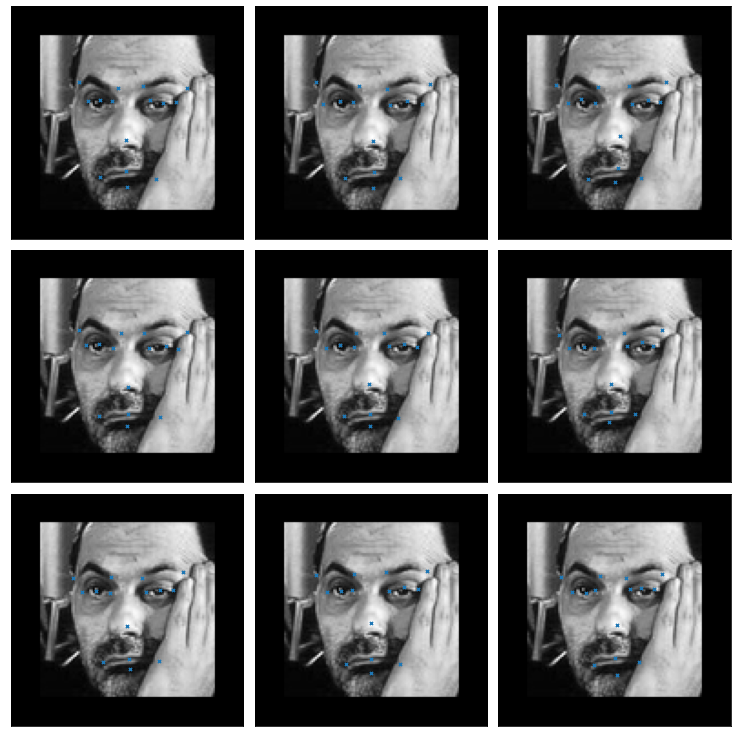

In [ ]:
image_vect = np.concatenate((image1,image1,image1,image1,image1,image1,image1,image1,image1))
fig = pyplot.figure(figsize=(10, 10))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(0,9):
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    plot_sample_general(image_vect[i,:,:,0],y_pred1[0,30*i:30*i + 30])

pyplot.show()

Look at the fifth picture. Is the one we are looking for!!

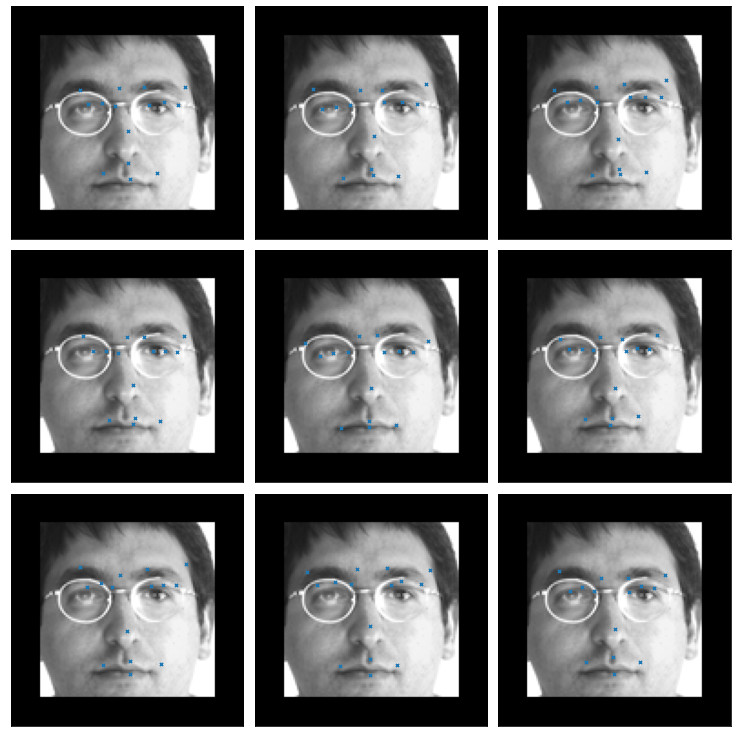

In [ ]:
image_vect = np.concatenate((image2,image2,image2,image2,image2,image2,image2,image2,image2))
fig = pyplot.figure(figsize=(10, 10))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(0,9):
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    plot_sample_general(image_vect[i,:,:,0],y_pred2[0,30*i:30*i + 30])

pyplot.show()

Look at the fifth picture. Is the one we are looking for!!

# Reporting

Please, report the results of your experiments in this cell.

## What is the best result you got when testing?  

> Results must be evaluated by computing the **mean error in pixel units**. If you get a mean error of 1.6 pixels is ok. If your get 1.5 is very good. If you get 1.4 or less, it is an outstanding result!

**Answer**: The mean pixel error is 1.3177782.

## What architecture and tricks you used for that result?
### Describe your design strategy as well all those tricks that contributed to your result.

**Answer**: The first thing that I focused on was on the data augmentation, as suggested at the beginning of the document. To begin with, I tried to flip the images horizontally but I got stuck because Keras layers, evidently, do not flip also the labels. I realized that I had to build my own function that flip the images and the labels correctly, and that is what I did. In addition, as I was "on fire" building my own functions, I decided to contuine in that way, instead of using Keras layers for data augmentation. Hence, I created an amount of functions for darken, brighten and blur an image. Once I got there, I thought that this was more than enough in relation to data augmentation and I moved on to focus on the model.

I tried different models to see their performance but after testing them, I decided to keep the one which is presented in the notebook. The final model presented has 8 convolutional layers, 4 max poolings and one dense layer. Moreover, I decided to add a dropout layer before the last dense layer in order to avoid overfitting. With all this, I managed to reach 1.4 mean pixel error, which was really good, but I wanted more!! I decided to go back to the data augmentation part, since I thought that increasing the number of data would improve the result as it had been up to now. Hence, I added a function that adds noise to an image, i.e., the function set 550 random points to 0 (550 black pixels). Much to my surprise, that did not increase my score, I got stuck in this 1.4 mean pixel error preventing me to reach an outstanding result.

I decided to change the course and focus on the batch size, the epochs, the optimizers, etc. Regarding to the epochs, I decided to implement early stopping with a patience of 10 iterations in order to forget about the epochs and let the early stopping be the one who stops the program. Hence, I fixed 500 epochs, that will never be realized because the early stopping. I also played with the batch size, setting it at the end at 16 since it was the one that gave me the best result. Finally, with respect the optimizer, I have tried three different ones, $\textit{tanh}$, $\textit{adam}$ and $\textit{SGD}$. The one that gave me the best result was $\textit{SGD}$ and that is why it is the one that appears in the delivered model. With all this, I managed to reach 1.3 mean pixel error!!

To conclude, I also want to say at least one thing that I implemented but was not successful. When I was stuck, before changing the course, I was focused on data augmentation and I tried to increase even more the data by concatenating what I had three times. Therefore, I managed to multiply by three the number of data I had, but of course, this did not provide any new information, since it was the same data and it is equivalent to inrease the number of epochs.


## What is the architecture of your FCN?
### Insert one of the test images in a larger image and show the detection result. The size of the face cannor change!
**Answer**: My FCN has the same structure of before but in order to make it independent of the image size, I changed the image size to (None,None,1) and I also changed the last dense layer to a convolutional one paying attention to the kernel size.




1/1 [==============================] - 0s 17ms/step


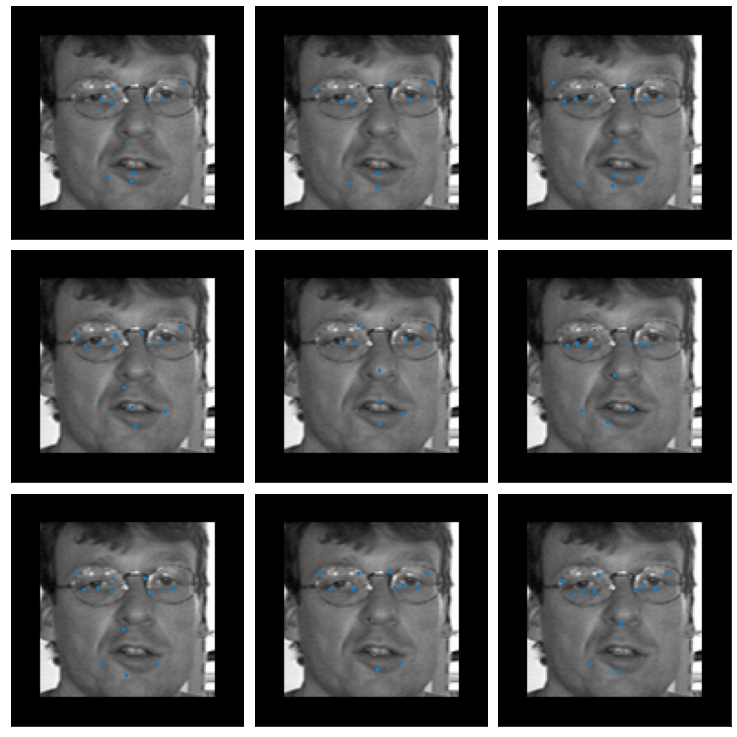

In [ ]:
image3 = np.expand_dims(np.pad(x_test[10][:,:,0],pad_width=16),axis=(0,3))#change the number if it is not clear enough
y_pred3 = model.predict(image3)

image_vect = np.concatenate((image3,image3,image3,image3,image3,image3,image3,image3,image3))
fig = pyplot.figure(figsize=(10, 10))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(0,9):
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    plot_sample_general(image_vect[i,:,:,0],y_pred3[0,30*i:30*i + 30])

pyplot.show()

Look at the fifth picture. Is the one we are looking for!!